# Sen12MS EDA 

Author: Ernesto Oropeza

## Key take away

* Sen12MS consist of 180662
* Each patch consist of 3 Geotif (Georeferenced) files that correspond to each satellites MODIS, Sentinel 1 and Sentinel 2.
* MODS includes 4 images.
* Sentinel 1 includes 2 images.
* Sentinel 2 includes 13 images
* The size of the images is 256x256 pixels
* There are 3847 naturally isolated. This means that no other patch of the rest of 180662 patches overlap them.
* We can select 35792 patches (out of 180662) that do not overlap with each other after discarding all the overlaping patches to them. 
* Most overlapping patches cover 25% and 50% of the selected areas.
* There are 0 patches overlapping over seasons
* 59 UTM zones are represented in the dataset but they are unevenly distributed
* Region IDs do not represent specific areas in this dataset

## Definitions

* ***Patch***. The area defined by its 4 geografic coordinates.
* ***UTM Zone***. The Universal Transverse Mercator grid. In this notebook south and north are different (e.g 34N and 34S)
* ***Images/Bands***. Every slice with information from each satelite. For example, S2 has 13 slices. Each slice is a band and we can display an image from each band.

### This notebook requires to instal geopandas and contextily. The following cell can be skipped if they are installed already

In [1]:
! pip install geopandas
! pip install contextily 

## Modules

In [2]:
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import rasterio
import numpy as np
from pyproj import Proj, transform
import json   

import warnings
warnings.filterwarnings('ignore')

## Setting root path and Data Frame Display

In [3]:
data_root = "/storage/sen12ms_x"
output_root = '/scratch/crguest/SEN12MS/utils/'
labels_root = '/scratch/crguest/SEN12MS/labels/'
pd.set_option('display.max_colwidth', 100)

## Full Labels

There are two list of labels: full lables (17) and simple labels (10). Simple labels generalize the features while full labels are more specific. For example, ***Shrublands*** is in simple list while in full they can be ***Closed (Dense) Shrublands*** and ***Open (Sparse) Shrublands***. The labels have a code number from each list. This cell creates one data frame with all patches and the respective lable and code. The order of this list correspond with the class number in the paper. 

In [4]:
class_full = [
    "Evergreen Needleleaf Forests",
    "Evergreen Broadleaf Forests",
    "Deciduous Needleleaf Forests",
    "Deciduous Broadleaf Forests",
    "Mixed Forests",
    "Closed (Dense) Shrublands",
    "Open (Sparse) Shrublands",
    "Woody Savannas",
    "Savannas",
    "Grasslands",
    "Permanent Wetlands",
    "Croplands",
    "Cropland/Natural Vegetation Mosaics",
    "Urban and Built-Up Lands",
    "Permanent Snow and Ice",
    "Barren",
    "Water Bodies"
]

class_simp = ['Forest', 'Shrublands', 'Savana', 'Grassland', 'Wetlands',
              'Croplands', 'Urban and Built-Up Lands','Permanent Snow and Ice','Barren','Water Bodies'
]

cf_dict = {}
cs_dict = {}
for i in range(len(class_full)):
    cf_dict[class_full[i]] = i+1
    
for i in range(len(class_simp)):
    cs_dict[class_simp[i]] = i+1

In [5]:
cf_df = pd.DataFrame(list(cf_dict.items()),columns = ['Full Lable','lfidex']) 
cs_df = pd.DataFrame(list(cs_dict.items()),columns = ['Simple Lable','lsidex']) 

In [6]:
cf_df.head(17)

,Full Lable,lfidex
0,Evergreen Needleleaf Forests,1
1,Evergreen Broadleaf Forests,2
2,Deciduous Needleleaf Forests,3
3,Deciduous Broadleaf Forests,4
4,Mixed Forests,5
5,Closed (Dense) Shrublands,6
6,Open (Sparse) Shrublands,7
7,Woody Savannas,8
8,Savannas,9
9,Grasslands,10


In [7]:
cs_df.head(10)

,Simple Lable,lsidex
0,Forest,1
1,Shrublands,2
2,Savana,3
3,Grassland,4
4,Wetlands,5
5,Croplands,6
6,Urban and Built-Up Lands,7
7,Permanent Snow and Ice,8
8,Barren,9
9,Water Bodies,10


## Including Label Names to Data Frame

Here full lable and simple label data frames are merged to create a new data frame with all the information.
The data frame ***both_lables*** has patch (with s2 satelite) with the respective label code.

In [8]:
full_labels = pd.read_csv(os.path.join(labels_root,'single_label_IGBPfull_ClsNum.txt'), delimiter = ":",header=None)
full_labels.columns=['Patch','lfidex']
simp_labels = pd.read_csv(os.path.join(labels_root,'single_label_IGBPsimple_ClsNum.txt'), delimiter = ":",header=None)
simp_labels.columns=['Patch','lsidex']
both_labels = pd.merge(full_labels,simp_labels,on='Patch',how='right')
both_labels.head()

,Patch,lfidex,lsidex
0,ROIs1158_spring_s2_128_p100.tif,13,7
1,ROIs1158_spring_s2_128_p101.tif,13,7
2,ROIs1158_spring_s2_128_p102.tif,13,7
3,ROIs1158_spring_s2_128_p103.tif,13,7
4,ROIs1158_spring_s2_128_p104.tif,13,7


Note that the label "Permanent Snow and Ice" don't have any patch asociated 

In [9]:
dfinal = both_labels.merge(cf_df, on="lfidex", how = 'outer').copy()
dfinal = dfinal.merge(cs_df, on="lsidex", how = 'outer').copy()
dfinal.tail()

,Patch,lfidex,lsidex,Full Lable,Simple Lable
180659,ROIs2017_winter_s2_81_p536.tif,16.0,9.0,Barren,Barren
180660,ROIs2017_winter_s2_119_p390.tif,16.0,9.0,Barren,Barren
180661,ROIs2017_winter_s2_119_p611.tif,16.0,9.0,Barren,Barren
180662,NaN,15.0,NaN,Permanent Snow and Ice,NaN
180663,NaN,NaN,8.0,NaN,Permanent Snow and Ice


## Splitting seed, season, sensor and tile

This cell createsa data frame ***tiles*** with a detail information from each file name : "seed","season","sensor","region" and "tile". The name of that data frame is tails.

In [10]:
tiles = pd.DataFrame(glob.glob(os.path.join(data_root,'*','*','*.tif')), columns=["path"])
split = tiles["path"].apply(lambda path: os.path.basename(path).split('_'))
split = pd.DataFrame.from_records(split, columns=["seed","season","sensor","region","tile"])
tiles = tiles.join(split)
tiles.head()

,path,seed,season,sensor,region,tile
0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,ROIs1970,fall,s1,149,p404.tif
1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p798.tif,ROIs1970,fall,s1,149,p798.tif
2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p810.tif,ROIs1970,fall,s1,149,p810.tif
3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p186.tif,ROIs1970,fall,s1,149,p186.tif
4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p510.tif,ROIs1970,fall,s1,149,p510.tif


In [11]:
tiles.tail()

,path,seed,season,sensor,region,tile
541981,/storage/sen12ms_x/ROIs1158_spring/s1_148/ROIs1158_spring_s1_148_p787.tif,ROIs1158,spring,s1,148,p787.tif
541982,/storage/sen12ms_x/ROIs1158_spring/s1_148/ROIs1158_spring_s1_148_p301.tif,ROIs1158,spring,s1,148,p301.tif
541983,/storage/sen12ms_x/ROIs1158_spring/s1_148/ROIs1158_spring_s1_148_p157.tif,ROIs1158,spring,s1,148,p157.tif
541984,/storage/sen12ms_x/ROIs1158_spring/s1_148/ROIs1158_spring_s1_148_p798.tif,ROIs1158,spring,s1,148,p798.tif
541985,/storage/sen12ms_x/ROIs1158_spring/s1_148/ROIs1158_spring_s1_148_p675.tif,ROIs1158,spring,s1,148,p675.tif


## Creating a final data frame with all information from each patch.

Note that this data frame includes 2 extra rows at the end that correspond to inexistent patches for "Permanent Snow and Ice".
The total number of patches are 180,662.
The patches are shown for Sentinel 2 (s2) but it is applicable to s1 and lc as well. s2 just needs to be replaced by s1 and lc respectivelly.

In [12]:
dfsplit= dfinal['Patch'].apply(lambda x: str(x)[:-4].split('_'))
dfsplit = pd.DataFrame.from_records(dfsplit, columns=["seed","season","sensor","region","tile"])
dfinal = dfinal.join(dfsplit)
dfinal

,Patch,lfidex,lsidex,Full Lable,Simple Lable,seed,season,sensor,region,tile
0,ROIs1158_spring_s2_128_p100.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p100
1,ROIs1158_spring_s2_128_p101.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p101
2,ROIs1158_spring_s2_128_p102.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p102
3,ROIs1158_spring_s2_128_p103.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p103
4,ROIs1158_spring_s2_128_p104.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p104
...,...,...,...,...,...,...,...,...,...,...
180659,ROIs2017_winter_s2_81_p536.tif,16.0,9.0,Barren,Barren,ROIs2017,winter,s2,81,p536
180660,ROIs2017_winter_s2_119_p390.tif,16.0,9.0,Barren,Barren,ROIs2017,winter,s2,119,p390
180661,ROIs2017_winter_s2_119_p611.tif,16.0,9.0,Barren,Barren,ROIs2017,winter,s2,119,p611
180662,NaN,15.0,NaN,Permanent Snow and Ice,NaN,,None,None,None,None


## Exploring Regions

There ara 125 different regions in this data set. However they do not represent a geographical area. \
In this section, the locations of a random sample of 100 patches from region 42 are ploted in the map below.

In [13]:
dfinal['region'].unique()

array(['128', '131', '132', '134', '138', '140', '141', '142', '143',
       '144', '145', '146', '147', '148', '44', '53', '63', '100', '101',
       '103', '106', '109', '110', '112', '113', '115', '117', '119',
       '120', '121', '122', '123', '124', '126', '127', '129', '133',
       '135', '137', '139', '14', '17', '19', '31', '56', '79', '81',
       '87', '102', '104', '114', '125', '6', '20', '21', '22', '33',
       '39', '71', '82', '83', '88', '91', '93', '105', '107', '116',
       '118', '130', '136', '149', '42', '64', '69', '84', '94', '108',
       '1', '8', '41', '77', '27', '47', '85', '90', '3', '40', '61',
       '32', '9', '15', '26', '45', '58', '75', '97', '11', '29', '43',
       '73', '80', '86', '25', '28', '30', '35', '36', '37', '59', '65',
       '49', '62', '7', '76', '95', '24', '4', '55', '72', '52', '78',
       '68', '66', '89', '57', None], dtype=object)

In [14]:
def get_cor_xy(path):
    with rasterio.open(path, 'r') as src:
        trafo = src.transform
        crs = src.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)

    return x,y

### More than a Region can be plotted at the same time. The more Regions are included the more time it is going to take to plot

In [15]:
region_pick = ['42','133'] # List of Regions to plot

maxplot = 100
region = tiles[tiles.region.isin(region_pick)]
region = region[region.sensor == 's1']
region_sample = region.sample(n=maxplot, random_state=1)
region_sample.reset_index(inplace = True)
xy = pd.DataFrame.from_records(region_sample["path"].apply(get_cor_xy), columns=["x","y"])
regionsxy = region_sample.reset_index().join(xy)
gdf = gpd.GeoDataFrame(regionsxy, geometry=gpd.points_from_xy(regionsxy.x, regionsxy.y),crs=4326).to_crs(epsg=3857)

(-20026376.39, 20026376.39, -10000000.0, 15000000.0)

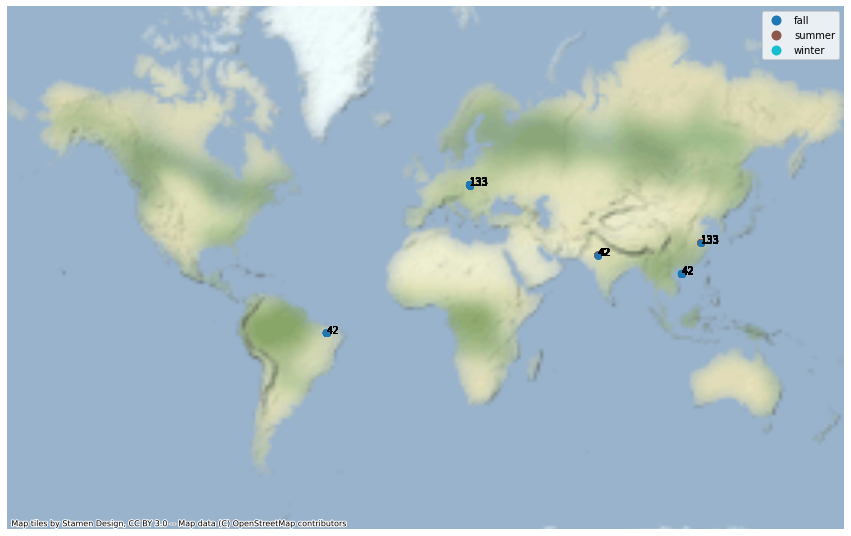

In [16]:
fig,ax=plt.subplots(figsize=(15,16))
gdf.plot(ax=ax,column="season",legend=True)
ax.scatter(gdf.geometry.x,gdf.geometry.y)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TerrainBackground,zoom=0)

for x,y,regionsxy in zip(gdf.geometry.x,gdf.geometry.y,gdf.region):
    ax.annotate(regionsxy,(x,y))

ax.set_xlim(-20026376.39,20026376.39)
ax.set_ylim(-1e7, 1.5e7)
ax.axis('off')

### Note that the same region can be in different locations

### Group by Lables

There are 2 data frame counting the number of patches per each label for full and simple cases

In [17]:
df_flabel = dfinal[['Full Lable','Patch']].groupby('Full Lable').count()
df_slabel = dfinal[['Simple Lable','Patch']].groupby('Simple Lable').count()

In [18]:
df_flabel.head(17)

,Patch
Full Lable,
Barren,9333
Closed (Dense) Shrublands,312
Cropland/Natural Vegetation Mosaics,20261
Croplands,31836
Deciduous Broadleaf Forests,7243
Deciduous Needleleaf Forests,14
Evergreen Broadleaf Forests,3836
Evergreen Needleleaf Forests,3847
Grasslands,29441


In [19]:
df_slabel.head(10)

,Patch
Simple Lable,
Barren,9332
Croplands,33967
Forest,19967
Grassland,28775
Permanent Snow and Ice,0
Savana,43175
Shrublands,12584
Urban and Built-Up Lands,19707
Water Bodies,11992


<AxesSubplot:xlabel='Simple Lable'>

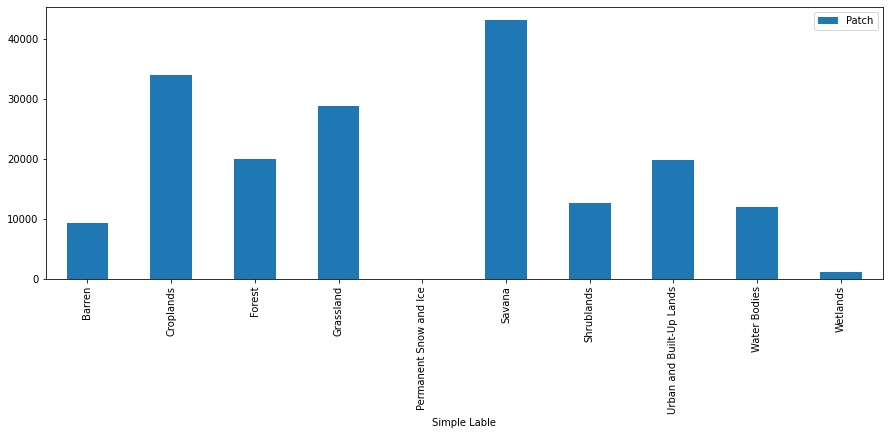

In [20]:
df_slabel.plot(y='Patch',kind='bar',figsize=(15,5))

<AxesSubplot:xlabel='Full Lable'>

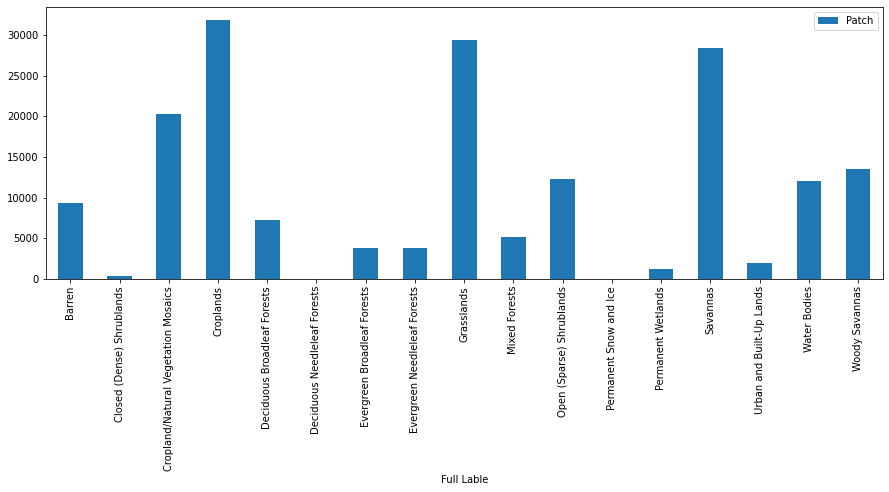

In [21]:
df_flabel.plot(y='Patch',kind='bar',figsize=(15,5))

## Patches distribution by regions

(125, 2)

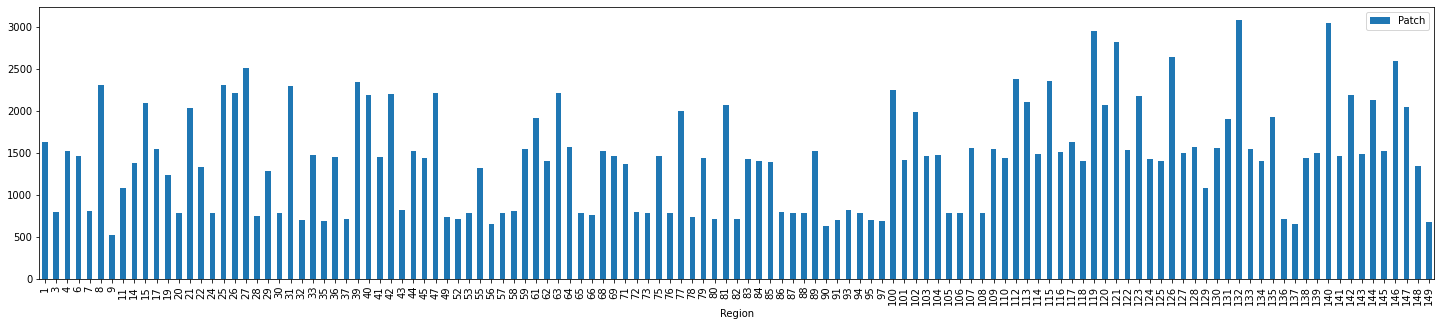

In [22]:
df_region = dfinal[['region','Patch']].groupby('region').count()
df_region = df_region.reset_index()
df_region['Region'] = df_region['region'].map(lambda x: int(x)) 
df_region.set_index('Region', inplace=True)
df_region.sort_index(inplace=True)
df_region.head()
df_region.plot(y='Patch',kind='bar',figsize=(25,5))
df_region.shape

### Group By Season

Shoing the number of patches by each season (Fall, Spring, Summer and Winter)

<AxesSubplot:xlabel='season'>

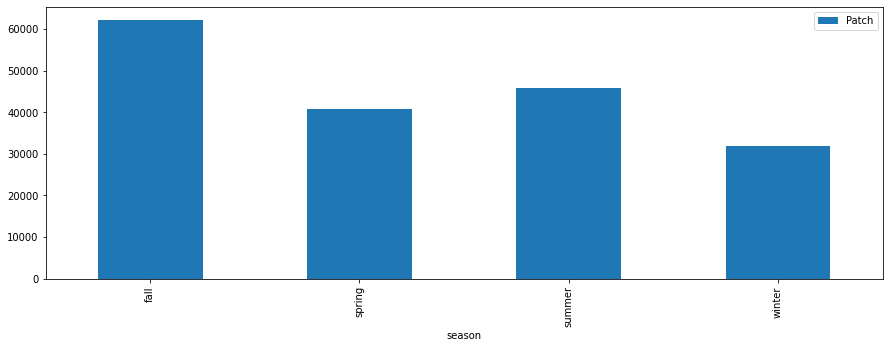

In [23]:
df_season = dfinal[['season','Patch']].groupby('season').count()
df_season.plot(y='Patch',kind='bar',figsize=(15,5))

## Ploting raw images

This is an example of a full patch in the data set. There are 4 images for MODIS, 2 for Sentinel-1 and 13 for Sentinel-2.

In [24]:
def plot_image(img_path):
    """
    This function plot a Geotiff file in Sen12Ms
    img_path: is the full path and name of the tif file
    """
    imf = rasterio.open(img_path)

    print(imf.meta)
    print(imf.bounds)
    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    print('Geographic Coordinates: Longitude: {}, Latitude: {}\n'.format(x,y))
    print('Image Size: ',image_array.shape)
    ni = image_array.shape[0]
    if ni > 4:
        nrow = int(ni/4)+1
        ncol = 4
    else:
        nrow = int(ni/4)+1
        ncol = 4

    fig = plt.figure(figsize=(20,10))

    for i in range(ni):
        plt.subplots_adjust(hspace=.2)
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(image_array[i],interpolation='nearest',cmap='viridis')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title('Band '+str(i+1), fontsize=14, color= 'white')

## Plotting an example 

In this case, the tail ***p426*** is plot to compare each band of each satelite.
Also, function ***plot_image*** prints some valuable information in a raw format:

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 256, 'height': 256, 'count': 4, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 391638.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=391638.4708795169, bottom=5889240.150648338, right=394198.4708795169, top=5891800.150648338)
Geographic Coordinates: Longitude: -70.21966862779055, Latitude: -37.11386450296634

Image Size:  (4, 256, 256)


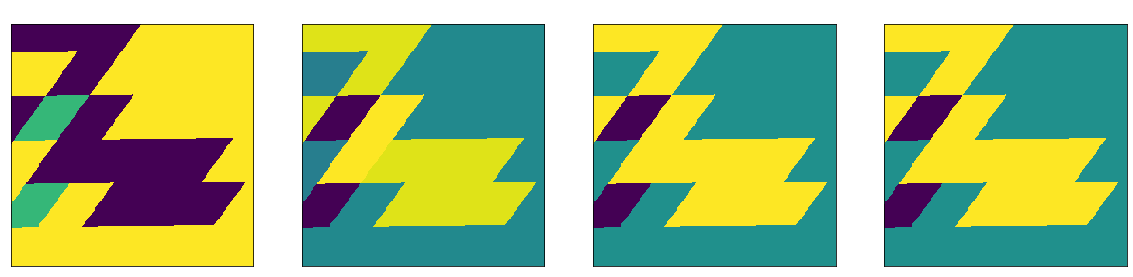

In [25]:
plot_image(data_root+'/ROIs2017_winter/lc_55/ROIs2017_winter_lc_55_p426.tif')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 391638.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=391638.4708795169, bottom=5889240.150648338, right=394198.4708795169, top=5891800.150648338)
Geographic Coordinates: Longitude: -70.21966862779055, Latitude: -37.11386450296634

Image Size:  (2, 256, 256)


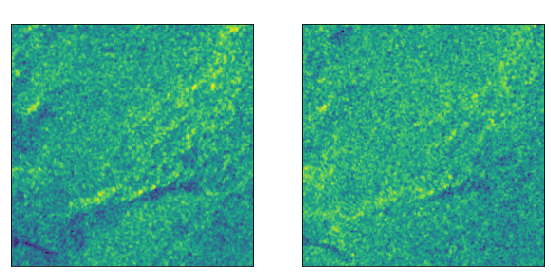

In [26]:
plot_image(data_root+'/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p426.tif')


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 256, 'height': 256, 'count': 13, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 391638.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=391638.4708795169, bottom=5889240.150648338, right=394198.4708795169, top=5891800.150648338)
Geographic Coordinates: Longitude: -70.21966862779055, Latitude: -37.11386450296634

Image Size:  (13, 256, 256)


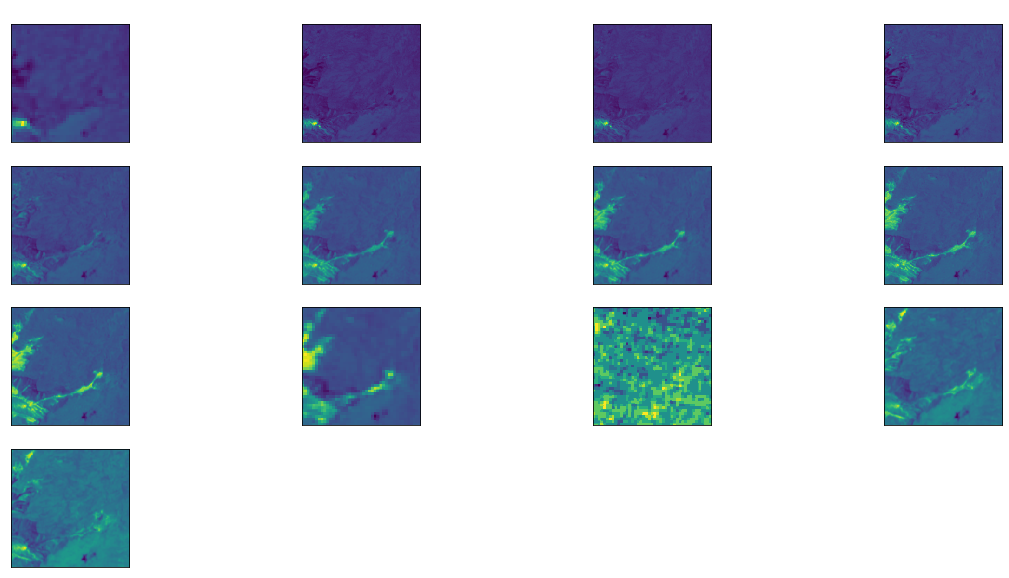

In [27]:
plot_image(data_root+'/ROIs2017_winter/s2_55/ROIs2017_winter_s2_55_p426.tif')

## Closest Distance

In this section, a data frame and a .csv file (distance_min_pair.csv) is created with the path of a pair of files that have the closest patches with respect to the same season (including the same season). The trivial solution (the patch itself) is excluded. The idea of this information is to explore possible overlaps between images in the seme season or any other.



In [28]:
# Calculating the distance between two points with their coordinates
import math as m
def distance(c1,c0):
    """
    This function calculate the distance between 2 geographical locations
    c1: is a tuple (latitude_1, longitude_1)
    c0: is a tuple (latitude_0, longitude_0)   
    """
    r = 6371.0 # in km
    lat1 = c1[0]
    lon1 = c1[1]
    lat0 = c0[0]
    lon0 = c0[1]
    lat0 = float(lat0)*m.pi/180.0
    lon0 = float(lon0)*m.pi/180.0
    lat1 = float(lat1)*m.pi/180.0
    lon1 = float(lon1)*m.pi/180.0
  
    a = m.sin(0.5*(lat1-lat0))**2 + m.cos(lat0)*m.cos(lat1)*m.sin(0.5*(lon1-lon0))**2
    c = 2.0*m.atan2(m.sqrt(a),m.sqrt(1-a))

    return r*c

In [29]:
def get_xy(img_path):
    """
    This function extract the geographic coordinates from a Gtiff file
    img_path: is the path to the GeoTiff file
    """
    imf = rasterio.open(img_path)

    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    
    return y,x

In [30]:
clpair_dic={'region':[],
            'distance':[],
            'file 1': [],
            'file 2': [],
            'season 1': [],
            'season 2': []
           }
df_clpair = pd.DataFrame(clpair_dic) 
seasons_list = ['fall','spring','summer','winter']
regions_list = tiles['region'].unique()
regions_list.sort()
regions_list

array(['1', '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '11', '110', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '124', '125', '126',
       '127', '128', '129', '130', '131', '132', '133', '134', '135',
       '136', '137', '138', '139', '14', '140', '141', '142', '143',
       '144', '145', '146', '147', '148', '149', '15', '17', '19', '20',
       '21', '22', '24', '25', '26', '27', '28', '29', '3', '30', '31',
       '32', '33', '35', '36', '37', '39', '4', '40', '41', '42', '43',
       '44', '45', '47', '49', '52', '53', '55', '56', '57', '58', '59',
       '6', '61', '62', '63', '64', '65', '66', '68', '69', '7', '71',
       '72', '73', '75', '76', '77', '78', '79', '8', '80', '81', '82',
       '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '93',
       '94', '95', '97'], dtype=object)

## Note: Next Cell may take 2 hours to be completed. If the file distance_min_pair.csv is available, it can be loaded

### This part writes CSV files with each patch and the closest corresponding patch in the same reagion meassured from the uper left corner

In [31]:
# for rid in regions_list:
#     print('Writing Region: {}'.format(rid))
#     region_select = tiles[(tiles['region'] == rid) & (tiles['sensor'] == 's1')]
#     xy = region_select["path"].map(get_xy)
#     region_select['xy']=xy

#     df_dict = {}
#     df_dict['fall'] = region_select[region_select.season == 'fall']
#     df_dict['spring'] = region_select[region_select.season == 'spring']
#     df_dict['summer'] = region_select[region_select.season == 'summer']
#     df_dict['winter'] = region_select[region_select.season == 'winter']

#     for i in region_select.index:
#         xo = region_select['xy'][i][1]
#         yo = region_select['xy'][i][0]
#         ss = region_select['season'][i]
#         print(xo,yo,ss)
#         for season_idx in seasons_list:
#             if df_dict[season_idx].size == 0:
#                 continue
#             xyd = []
#             for j in df_dict[season_idx].index:
#                 if i==j:
#                     xyd.append(9.99999990e+20)
#                 else:
#                     xyd.append(distance(df_dict[season_idx]['xy'][j],(yo,xo)))
#             xyd2 = np.array(xyd)
#             jj = df_dict[season_idx].index[xyd2.argmin()]
#             df_clpair.loc[len(df_clpair.index)] = [rid,xyd2.min(),
#                                                    region_select['path'][i],
#                                                    df_dict[season_idx]['path'][jj],
#                                                    ss,season_idx
#                                                   ]

#     df_clpair.to_csv(os.path.join(output_root,'/close_patches/distance_min_pair_region_'+rid+'_v2.csv'))
#     df_clpair = df_clpair.iloc[0:0]

## Do patches acquired in different sessions overlap?

To answer this question we are compareing the minimum distance between patches if they correspond to different season. This cell reads the csv files created in the previous cell.

In [32]:
dist_clt_list =glob.glob(os.path.join(output_root,'close_patches/distance_min_pair_region_*.csv'))

dist = 2.5
cont = 0
for filein in dist_clt_list:
    dfcurr = pd.read_csv(filein)
    dfcurr.rename(columns={"season 1": "season1", "season 2": "season2"}, inplace=True)
    
    if cont == 0:
        short_distance = dfcurr[(dfcurr.season1 != dfcurr.season2) & (dfcurr.distance < dist)].copy()
    else:
        short_distance.append(dfcurr[(dfcurr.season1 != dfcurr.season2) & (dfcurr.distance < dist)])
    cont=+1

print('There are {} patches overlaping'.format(short_distance.shape[0]))

if short_distance.shape[0] > 0:
    short_distance.head()

There are 0 patches overlaping


### What is the minimum distance between patches in each region?

In [33]:
dist_clt_list = glob.glob(os.path.join(output_root,'close_patches/distance_min_pair_region_*.csv'))

dis_dict = {}
for filein in dist_clt_list:
    dfcurr = pd.read_csv(filein)
    dfcurr.reset_index(inplace=True)
    dfcurr.rename(columns={"season 1": "season1", "season 2": "season2"}, inplace=True)
    region = int(dfcurr['region'].unique()[0]) 
    dfcurr = dfcurr[dfcurr.season1 != dfcurr.season2]
     
    if dfcurr.shape[0] == 0:
        dis_dict[region] = None
    else:
        dis_dict[region] = dfcurr['distance'].to_numpy().min()

In [34]:
region_id = []
distance = []
single_season = []
for item in dis_dict.items():
    if item[1] == None:
        single_season.append(item[0])
    else:
        region_id.append(item[0])
        distance.append(item[1])  

## Regions that only include one season

In [35]:
# Single sessions regions
print('There are {} regions with single sessions: \n {}'.format(len(single_season),np.array(single_season)))

There are 39 regions with single sessions: 
 [ 73  91  57  66  94  37 137  35  78  88  82  43  24  86  56  58  72 149
  76   7  95   3 136  90  49 105 108  28  97  30  20  52  65  53   9  87
  80  32 106]


## Ploting minimum distance between patches per region

Text(0, 0.5, 'Distance (Km)')

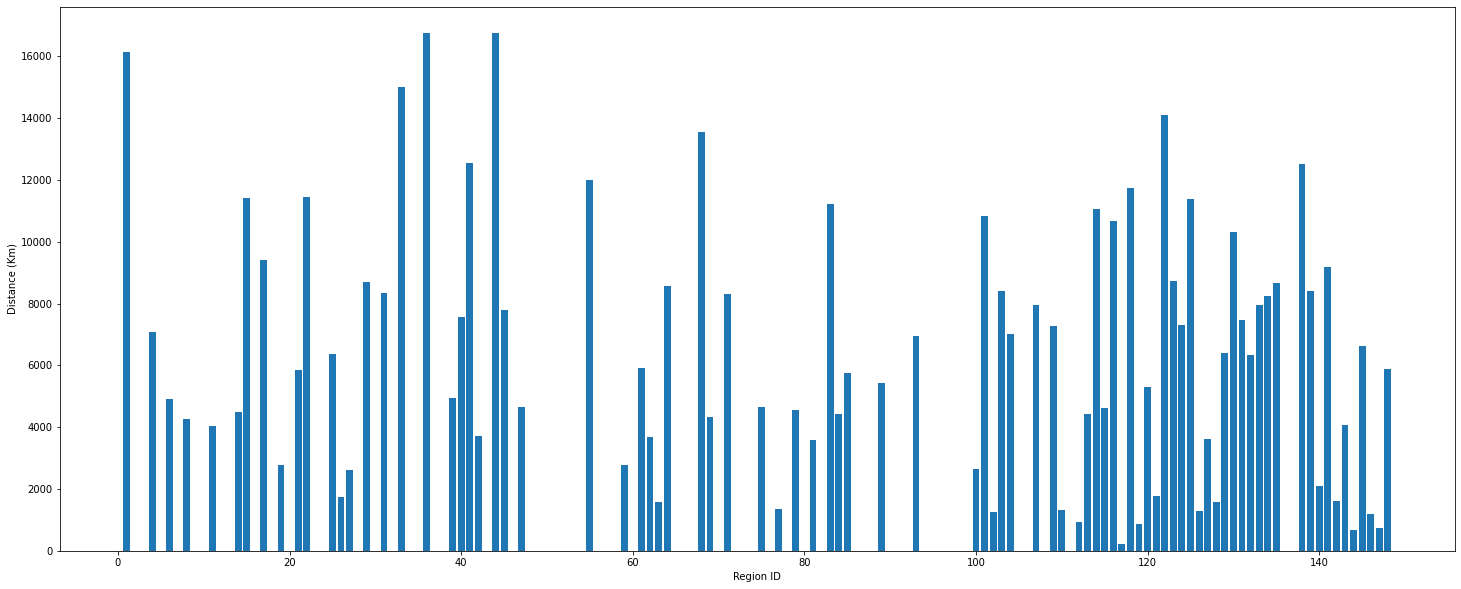

In [36]:
plt.figure(figsize=(25,10))
plt.bar(region_id,distance)
plt.xlabel('Region ID')
plt.ylabel('Distance (Km)')

### Shortest distance between paths from different seasons

In [37]:
print('Shortest distance between paths from different seasons')
print(region_id[np.array(distance).argmin()],np.array(distance).min())

Shortest distance between paths from different seasons
117 205.0355625050295


## Grouping by UTM Zones

Now we separate patches for their UTM Zones. The objetive is to determine overlapping areas.
The asumption is that tow patches from adjacent UTM zones do not overlap.

### Making an utm folder if does not exist

In [38]:
utmpath = os.path.join(output_root,'close_patches/utm_zones')
try:
    os.mkdir(utmpath)
except:
    pass

### Extracting all patches for one satelite (s1 in this case)

In [39]:
all_patch = tiles[(tiles['sensor'] == 's1')].copy()
all_patch.head()

,path,seed,season,sensor,region,tile
0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,ROIs1970,fall,s1,149,p404.tif
1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p798.tif,ROIs1970,fall,s1,149,p798.tif
2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p810.tif,ROIs1970,fall,s1,149,p810.tif
3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p186.tif,ROIs1970,fall,s1,149,p186.tif
4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p510.tif,ROIs1970,fall,s1,149,p510.tif


In [40]:
def get_zone(pathin):
    """
    This function returns the UTM zone from a geotiff file given by its full path
    """
    imf = rasterio.open(pathin)
    phrase = imf.crs.wkt
    phrase2 = phrase.split(',')[0]
    idx = phrase2.index('UTM zone')
    
    return phrase2[idx+9:-1]

In [41]:
def get_all_geo(img_path):
    """
    This function extract the geographic coordinates from a Gtiff file
    img_path: is the path to the GeoTiff file
    """
    imf = rasterio.open(img_path)

    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    # Coordinates
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    
    #UTM Zone
    phrase = imf.crs.wkt
    phrase2 = phrase.split(',')[0]
    idx = phrase2.index('UTM zone')
    boxc = (imf.bounds.left, imf.bounds.bottom, imf.bounds.right, imf.bounds.top)
    return phrase2[idx+9:-1], (y,x), boxc

### Here we map the geographic coordinates and the UTM box (4 edges coordinates: left, bottom, rigth and top respectivelly) from each patch in the data frame

## Note: This may take about 5 hours to be completed in this implementation. If available read the file ***patches_with_georef.csv***. Else, uncomment below and run.

In [42]:
# Extracting UTM Zone
# all_patch['utm_zone'], all_patch['xy'],all_patch['patch_box'] = zip(*all_patch['path'].map(get_all_geo))
# all_patch.to_csv(os.path.join(output_root,'close_patches/utm_zones/patches_with_georef.csv'))

## Ploting number of patches per UTM Zone

This section reads the cvs file ***patches_with_georef.csv*** created in the previous cell

In [43]:
all_patch = pd.read_csv(os.path.join(output_root,'close_patches/utm_zones/patches_with_georef.csv'))
all_patch.head()

,Unnamed: 0,path,seed,season,sensor,region,tile,utm_zone,xy,patch_box
0,0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,ROIs1970,fall,s1,149,p404.tif,31N,"(44.07562812096069, 2.365465563255205)","(449191.3963381321, 4877908.455379836, 451751.3963381321, 4880468.455379836)"
1,1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p798.tif,ROIs1970,fall,s1,149,p798.tif,31N,"(43.91307548439412, 2.175891998851004)","(433831.3963381321, 4859988.455379836, 436391.3963381321, 4862548.455379836)"
2,2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p810.tif,ROIs1970,fall,s1,149,p810.tif,31N,"(43.91429496780011, 2.3671824235043046)","(449191.3963381321, 4859988.455379836, 451751.3963381321, 4862548.455379836)"
3,3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p186.tif,ROIs1970,fall,s1,149,p186.tif,31N,"(44.154705308289564, 2.124515872932423)","(429991.3963381321, 4886868.455379836, 432551.3963381321, 4889428.455379836)"
4,4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p510.tif,ROIs1970,fall,s1,149,p510.tif,31N,"(44.02853542293907, 2.2062395295808646)","(436391.3963381321, 4872788.455379836, 438951.3963381321, 4875348.455379836)"


In [44]:
utm_zones = all_patch['utm_zone'].unique()
print('{} UTM Zones are represented in the data'.format(utm_zones.shape[0]))

59 UTM Zones are represented in the data


In [45]:
df_zone = all_patch[['sensor','utm_zone']].groupby('utm_zone').count()
df_zone.rename(columns={'sensor': 'NumberOfPatches'}, inplace=True)
print('Number of patches: {}'.format(df_zone['NumberOfPatches'].sum()))

Number of patches: 180662


<AxesSubplot:xlabel='utm_zone'>

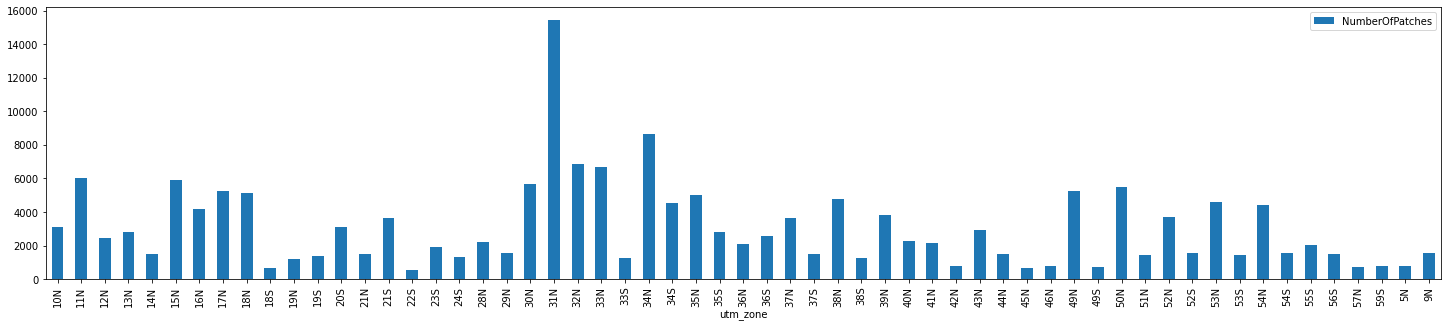

In [46]:
df_zone.plot(y='NumberOfPatches',kind='bar',figsize=(25,5))

In [47]:
# clpair_dic={'utm_zone':[],
#             'distance':[],
#             'file1': [],
#             'file2': [],
#             'season1': [],
#             'season2': []
#            }
# df_clpair = pd.DataFrame(clpair_dic) 
# seasons_list = ['fall','spring','summer','winter']

## Overlapping Patches

This section creates a list with selected patches that do not overlap with each other.
It compares each patch inside the same UTM zone.
The implementation selects the first available patch in a list, append it to a selected list and include it in a dictionary as a key. 
This selection is compared with all other patches in the list by using the function ***overlap_pct*** (below) that returns 0 if ther is not overlap and the porcentage of the overlapping area if overlapping.
Then any overlapping with respaect to the selection is popped from the list and included in the dictionary as an item to the selected patch along with the overlapping area percentage.
This runs until the list at each utm zone is empty and re-start to other UTM zone.
There are 2 output files per each UTM zone.

In [48]:
def overlap_pct(b1,bref):
    
    # From https://www.geeksforgeeks.org/find-two-rectangles-overlap/ #This code is contributed by Vivek Kumar Singh
    # Python program to check if rectangles overlap 
    class Point: 
        def __init__(self, x, y): 
            self.x = x 
            self.y = y 

    # returns true if two rectangles(l1, r1)  
    # and (l2, r2) overlap 
    def doOverlap(l1, r1, l2, r2): 

        # If one rectangle is on left side of other 
        if(l1.x >= r2.x or l2.x >= r1.x): 
            return False

        # If one rectangle is above other 
        if(l1.y <= r2.y or l2.y <= r1.y): 
            return False

        return True
    
    bl0 = Point(bref[0],bref[3]) 
    br0 = Point(bref[2],bref[1])
    bl1 = Point(b1[0],b1[3]) 
    br1 = Point(b1[2],b1[1])

    # Area of Reference Box
    k2 = 1e-06  
    b0_area = k2*np.abs((bref[0]-bref[2])*(bref[1]-bref[3]))

    if(doOverlap(bl1, br1, bl0, br0)): 
        if bl1.x <= bl0.x:
            xl = bl0.x
            xr = br1.x
            if bl1.y >= bl0.y:
                yl = bl0.y
                yr = br1.y
            else:
                yl = bl1.y
                yr = br0.y   
        else:
            xl = bl1.x
            xr = br0.x
            if bl1.y >= bl0.y:
                yl = bl0.y
                yr = br1.y       
            else:
                yl = bl1.y
                yr = br0.y

        olap_area = k2*np.abs((xl-xr)*(yl-yr))
        olap_pct = olap_area/b0_area*100.0
        return olap_pct 
    else: 
        return 0.0  

## Note: This part may 1 hour to be completed. Uncomment and run if the files in selected patches and overlap patches do net exist

In [49]:
# tol = 0.1
# overlap_threshold = 0.0 # maximum overlap allowed

# number_utm = len(utm_zones)
# cont_utm = 1
# for utmz in utm_zones:
#     utm_select = all_patch[(all_patch['utm_zone'] == utmz)]
#     utm_select.reset_index(inplace=True)

#     patches = utm_select['path'].tolist()
#     boxes = utm_select['patch_box'].tolist()
    
#     selected_patch=[]
#     discarted_patch={}
#     cont=0
#     while patches != []:
#         patch0 = patches.pop(0)
#         box0 = boxes.pop(0)
#         selected_patch.append(patch0)
#         discarted_patch[patch0] = []
        
#         n = len(patches)
#         for _ in range(n):
#             patch1 = patches.pop(0)
#             box1 = boxes.pop(0)
#             opct = overlap_pct(box1,box0) # Compute overlapping
#             if opct > overlap_threshold+tol:
#                 discarted_patch[patch0].append((patch1,opct))
#             else:
#                 patches.append(patch1)
#                 boxes.append(box1)
        
#         cont+=1
#         if cont%100 == 0:
#             print('Working on UTM {} ({} of {}). Patches remaining: {}...'.format(utmz,cont_utm,number_utm,len(patches)))
    
#     print('Writing Files for UTM {}'.format(utmz))
#     with open(utmpath+'/selected_patches/selected_patches_'+utmz+'.txt', 'w') as fileout:
#         fileout.writelines("%s\n" % patchin for patchin in selected_patch)
    
#     with open(utmpath+'/overlap_patches/ovelap_patches_'+utmz+'.json', "w") as outfile:  
#         json.dump(discarted_patch, outfile)
    
#     cont_utm +=1 


### How many patches without overlaping where extracted from data, in total and per UTM Zone?



The total patches that are not overlapping are 35792 out of 180662.


<AxesSubplot:xlabel='utm_zone'>

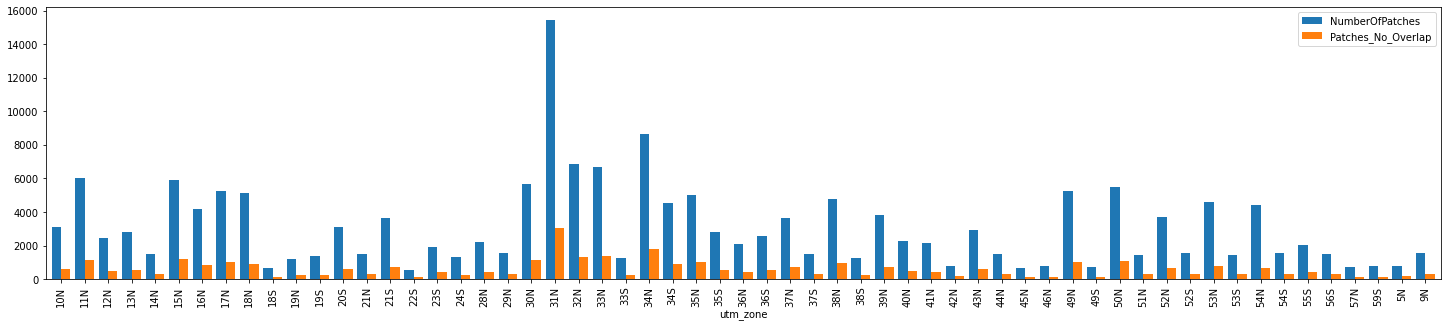

In [50]:
df_zone2 = df_zone.copy()

utm_index = []
ovlap = []
for filein in os.listdir(utmpath+'/selected_patches/'):
    if '.txt' not in filein:
        continue
    
    utmff = filein[17:-4]

    a_file = open(utmpath+'/selected_patches/'+filein, "r")
    list_of_lists = []
 
    for line in a_file:
        stripped_line = line.strip()
        line_list = stripped_line.split()
        list_of_lists.append(line_list)
        
    utm_index.append(utmff)
    ovlap.append(len(list_of_lists))
    
data = np.array(ovlap)
df_zone2['Patches_No_Overlap'] = pd.Series(data,index=utm_index)

total_patches = df_zone2['NumberOfPatches'].sum()
no_overlap = df_zone2['Patches_No_Overlap'].sum()
print('The total patches that are not overlapping are {} out of {}.'.format(no_overlap,total_patches))
df_zone2.plot.bar(rot=90,figsize=(25,5),width=0.8)

## What is the overlap between the discarded patches with respect to the selected patches?

## Note: This cell may take 1 hour to run. Uncomment to run it if the following csv are not created yet.
* close_patches/utm_zones/discarded_selected_pair.csv
* close_patches/utm_zones/selected_with_number_overlap.csv

In [51]:
# df_oldic = pd.DataFrame({'path':[],'overlap':[]}) 
# df_olpctdic = pd.DataFrame({'discarded_path':[],'selected_patch':[],'overlappct':[],'bucket':[]}) 

# cont_sel = 0
# cont_dis = 0
# # tot_sel = 0
# # tot_dis = 0
# for filein in os.listdir(utmpath+'/overlap_patches/'):
#     if '.json' not in filein:
#         continue

#     with open(utmpath+'/overlap_patches/'+filein) as utm_json: 
#         utm_dict = json.load(utm_json)
# #         tot_sel += len(utm_dict.keys())
#         for sel_patch in utm_dict.keys():
#             df_oldic.loc[cont_sel] = [sel_patch, str(len(utm_dict[sel_patch]))]
#             cont_sel += 1
#             for item in utm_dict[sel_patch]:
#                 if item[1] <= 15.0:
#                     catg = '0-15'
#                 elif item[1] <= 25.0:
#                     catg = '15-25'
#                 elif item[1] <= 50.0:
#                     catg = '25-50'
#                 elif item[1] <= 75.0:
#                     catg = '50-75'
#                 else:
#                     catg = '75-100'
                
#                 df_olpctdic.loc[cont_dis] = [item[0],sel_patch,item[1],catg]
#                 cont_dis += 1
#     print('{} file completed'.format(filein))
    
# df_olpctdic.to_csv(os.path.join(output_root,'close_patches/utm_zones/discarded_selected_pair.csv'))
# df_oldic.to_csv(os.path.join(output_root,'close_patches/utm_zones/selected_with_number_overlap.csv'))

## Reading csv files created in the previous cell

In [52]:
df_olpctdic = pd.read_csv(os.path.join(output_root,'close_patches/utm_zones/discarded_selected_pair.csv'))
df_oldic = pd.read_csv(os.path.join(output_root,'close_patches/utm_zones/selected_with_number_overlap.csv'))

In [53]:
df_olpctdic.head()

,Unnamed: 0,discarded_path,selected_patch,overlappct,bucket
0,0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p375.tif,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,50.0,25-50
1,1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p403.tif,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,50.0,25-50
2,2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p374.tif,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,25.0,15-25
3,3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p376.tif,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,25.0,15-25
4,4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p434.tif,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,25.0,15-25


In [54]:
df_oldic.head()

,Unnamed: 0,path,overlap
0,0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif,8
1,1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p798.tif,12
2,2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p810.tif,24
3,3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p186.tif,8
4,4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p510.tif,8


## This table shows the number of patches with respect to the selected patch by poverlapping percentage area

In [55]:
df_olpctdic[['discarded_path','bucket']].groupby('bucket').count()

,discarded_path
bucket,
0-15,1313
15-25,60195
25-50,82618
50-75,529
75-100,215


## From selected patch (without overlapping each other), how many patches were discarded because they were overlapping?

In [56]:
sel_olap_stat = df_oldic.groupby('overlap').count()
sel_olap_stat.reset_index(inplace=True)
sel_olap_stat['NumberOfOverlap'] = sel_olap_stat['overlap'].map(lambda x: int(x))
sel_olap_stat.sort_values(by='NumberOfOverlap',inplace=True)
sel_olap_stat.reset_index(inplace=True)
sel_olap_stat.drop(columns=['index','overlap'],inplace=True)
sel_olap_stat

,Unnamed: 0,path,NumberOfOverlap
0,3847,3847,0
1,5178,5178,1
2,3393,3393,2
3,4565,4565,3
4,2827,2827,4
5,4922,4922,5
6,3175,3175,6
7,1261,1261,7
8,6311,6311,8
9,27,27,9


## Ploting An Example of Overlapping images 

In this section an example is plotted to show a selected images with 2 of the discaded images with overlap. The files are listed below.

### Selected Patch:
  * /storage/sen12ms_x/ROIs1970_fall/s1_82/ROIs1970_fall_s1_82_p595.tif

### Discarded Patches - Overlap (%)
"/storage/sen12ms_x/ROIs1970_fall/s1_82/ROIs1970_fall_s1_82_p567.tif" - 25 \
"/storage/sen12ms_x/ROIs1970_fall/s1_82/ROIs1970_fall_s1_82_p624.tif" - 50 \
"/storage/sen12ms_x/ROIs1970_fall/s1_82/ROIs1970_fall_s1_82_p594.tif" - 50 \
"/storage/sen12ms_x/ROIs1970_fall/s1_82/ROIs1970_fall_s1_82_p623.tif" - 25 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p782.tif" - 13.607865716755786 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p809.tif" - 55.16584850632182 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p839.tif" -54.50791272943899 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p840.tif" - 23.062315026888992 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p838.tif" - 39.828880378211025 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p837.tif" - 8.383282675661011 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p781.tif" - 32.16226801420579 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p810.tif" - 75.49735838602818 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p808.tif" - 11.611446208871822 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p811.tif" - 31.94295608857818 \
"/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p779.tif" - 4.946536580694211

The bleu area corrsponds to the selected image and the 2 red areas were discarded for overlapping the selected area 

In [57]:
from matplotlib.patches import Rectangle

def only_bounds(img_path):
    imf = rasterio.open(img_path)
    return imf.bounds

(4734609.324543147, 4743169.324543147)

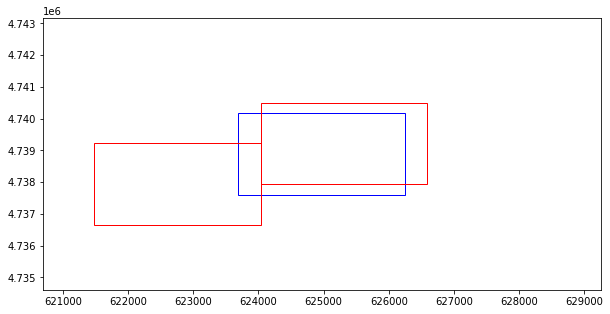

In [58]:
img_path1 = '/storage/sen12ms_x/ROIs1970_fall/s1_82/ROIs1970_fall_s1_82_p595.tif'
img_path2 = '/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p810.tif'
img_path3 = '/storage/sen12ms_x/ROIs1158_spring/s1_71/ROIs1158_spring_s1_71_p837.tif'
p1 = only_bounds(img_path1)
p2 = only_bounds(img_path2)
p3 = only_bounds(img_path3)

fig, ax = plt.subplots(figsize=(10,5))

ax.add_patch(Rectangle((p1.left, p1.top), p1.right-p1.left, p1.bottom-p1.top,fill=False,edgecolor = 'blue'))
ax.add_patch(Rectangle((p2.left, p2.top), p2.right-p2.left, p2.bottom-p2.top,fill=False,edgecolor = 'red'))
ax.add_patch(Rectangle((p3.left, p3.top), p3.right-p3.left, p3.bottom-p3.top,fill=False,edgecolor = 'red'))

ax.set_xlim([p1.left-3000,p1.right+3000])
ax.set_ylim([p1.bottom-3000,p1.top+3000])

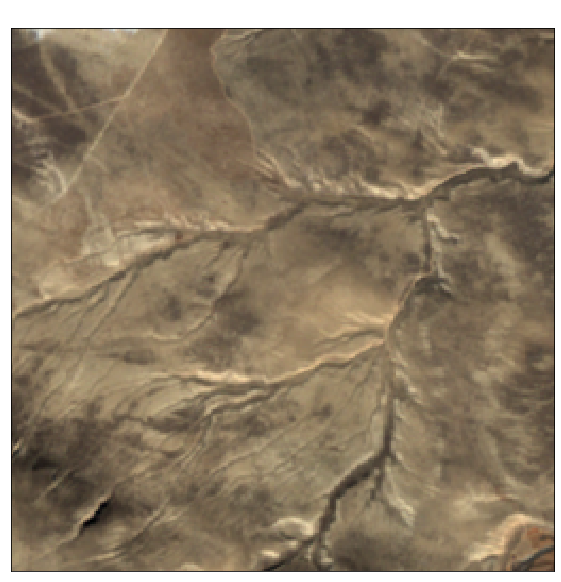

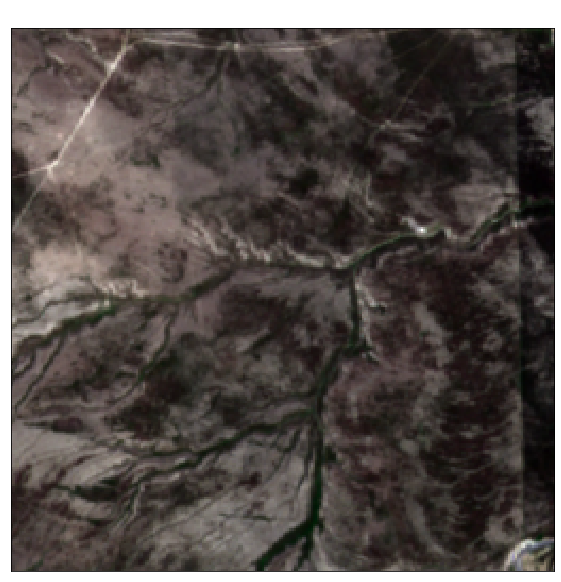

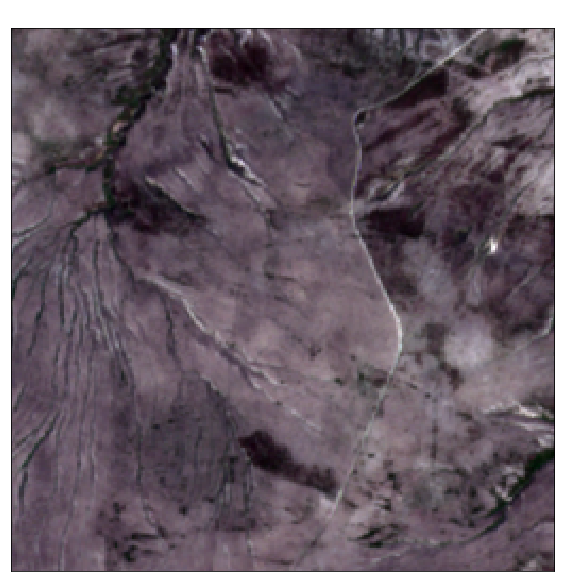

In [59]:
from PIL import Image
import numpy as np
def plot_image_rgb(img_path,name):

    def rescale(arr):
        arr_min = arr.min()
        arr_max = arr.max()
        return (arr - arr_min) / (arr_max - arr_min)

    imf = rasterio.open(img_path)

    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    rgbArray = np.zeros((256,256,3), 'uint8')
    rgbArray[..., 0] = 255.0 * rescale(image_array[3])
    rgbArray[..., 1] = 255.0 * rescale(image_array[2])
    rgbArray[..., 2] = 255.0 * rescale(image_array[1])


    fig = plt.figure(figsize=(15,10))

    plt.subplots_adjust(hspace=.1)

    plt.imshow(rgbArray,interpolation='nearest',cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(name, fontsize=20, color='white')
    
    
img_path = '/storage/sen12ms_x/ROIs1970_fall/s2_82/ROIs1970_fall_s2_82_p595.tif'
plot_image_rgb(img_path,'Selected Image - Fall')
img_path = '/storage/sen12ms_x/ROIs1158_spring/s2_71/ROIs1158_spring_s2_71_p810.tif'
plot_image_rgb(img_path,'Discarded Image (75% Overlap) - Sring')
img_path = '/storage/sen12ms_x/ROIs1158_spring/s2_71/ROIs1158_spring_s2_71_p837.tif'
plot_image_rgb(img_path,'Discarded Image (13% Overlap) - Sring')